In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from PIL import Image
from keras.preprocessing import image

In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.1, zoom_range=(0.5,1.5), rotation_range=60, brightness_range=(0.5,1.5))
train_generator = train_datagen.flow_from_directory(
        '../input/covid19-lung-ct-scans/COVID-19_Lung_CT_Scans/',  
        target_size=(256, 256),  
        batch_size=128,
        class_mode='binary',
        subset='training')
    
validation_generator  = train_datagen.flow_from_directory(
        '../input/covid19-lung-ct-scans/COVID-19_Lung_CT_Scans/',  
        target_size=(256, 256),  
        batch_size=128,
        class_mode='binary',
        subset='validation')

Found 7596 images belonging to 2 classes.
Found 843 images belonging to 2 classes.


In [4]:
validation_generator.batch_size = 247
X,y = validation_generator.next()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

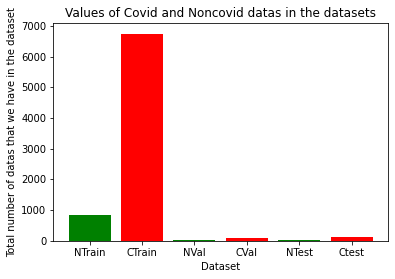

Numerically:
NTrain: 850
CTrain: 6746
NVal: 16.0
CVal: 107.0
NTest: 13.0
CTest: 111.0


In [5]:
noncovid_datas_train = train_generator.labels.sum()
covid_datas_train = train_generator.labels.size-noncovid_datas_train
noncovid_datas_valid = y_train.sum()
covid_datas_valid = y_train.size - y_train.sum()
noncovid_datas_test = y_test.sum()
covid_datas_test = y_test.size - y_test.sum()

x = ['NTrain', 'CTrain', 'NVal', 'CVal', 'NTest', 'Ctest']
sizes = [noncovid_datas_train, covid_datas_train, noncovid_datas_valid, covid_datas_valid, noncovid_datas_test, covid_datas_test]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, sizes, color=('green', "red"))
plt.xlabel("Dataset")
plt.ylabel("Total number of datas that we have in the dataset")
plt.title("Values of Covid and Noncovid datas in the datasets")
plt.xticks(x_pos, x)
plt.show()
print("Numerically:")
print("NTrain:",noncovid_datas_train)
print("CTrain:",covid_datas_train)
print("NVal:",noncovid_datas_valid)
print("CVal:",covid_datas_valid)
print("NTest:",noncovid_datas_test)
print("CTest:",covid_datas_test)

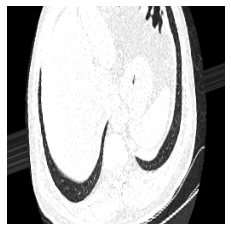

Covid


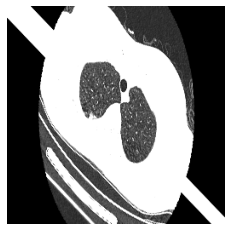

Covid


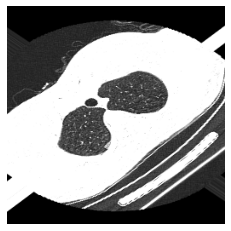

Covid


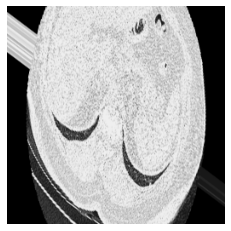

Covid


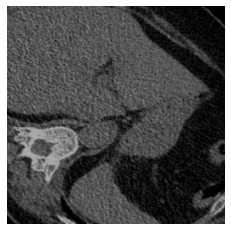

Covid


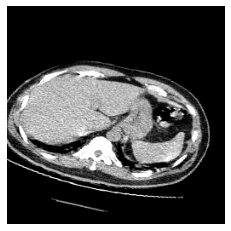

Covid


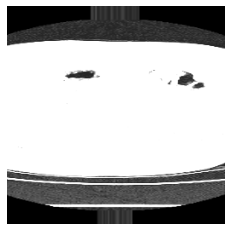

Covid


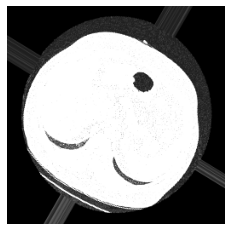

Covid


In [6]:
for i in range (1,9):
    a=np.random.randint(0,120)
    plt.imshow(X_test[a])
    plt.axis('Off')
    plt.show()
    if y_test[a] ==1:
        print("Noncovid")
    else:
        print("Covid")

In [7]:
import tensorflow as tf
inception=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(256,256,3),weights='imagenet')
#pretrain_model_path = '/content/drive/My Drive/v3.h5'
layer=inception.get_layer('mixed7')
#x.load_weights(pretrain_model_path)
x=tf.keras.layers.Flatten()(layer.output)
x=tf.keras.layers.Dense(units=1024,activation='relu')(x)
x=tf.keras.layers.Dense(units=512,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs=inception.input,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])

performance_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 2)

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_____________________________

In [8]:
train_generator.batch_size = 32
history = model.fit(train_generator, epochs =50,validation_data=(X_train, y_train))

Epoch 1/50
238/238 [==============================] - 198s 772ms/step - loss: 0.2945 - acc: 0.9220 - f1_m: 0.4642 - precision_m: 0.5547 - recall_m: 0.4523 - val_loss: 0.6711 - val_acc: 0.8862 - val_f1_m: 0.1833 - val_precision_m: 0.5000 - val_recall_m: 0.1125
Epoch 2/50
238/238 [==============================] - 161s 678ms/step - loss: 0.0830 - acc: 0.9703 - f1_m: 0.8314 - precision_m: 0.8945 - recall_m: 0.8162 - val_loss: 1.9071 - val_acc: 0.9187 - val_f1_m: 0.5524 - val_precision_m: 1.0000 - val_recall_m: 0.3875
Epoch 3/50
238/238 [==============================] - 162s 681ms/step - loss: 0.0685 - acc: 0.9790 - f1_m: 0.8743 - precision_m: 0.9127 - recall_m: 0.8684 - val_loss: 0.4647 - val_acc: 0.9675 - val_f1_m: 0.8542 - val_precision_m: 1.0000 - val_recall_m: 0.7750
Epoch 4/50
238/238 [==============================] - 162s 678ms/step - loss: 0.0425 - acc: 0.9862 - f1_m: 0.8918 - precision_m: 0.9167 - recall_m: 0.8838 - val_loss: 1.3911 - val_acc: 0.9106 - val_f1_m: 0.4095 - val_pre

In [9]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 137ms/step - loss: 0.0121 - acc: 0.9919 - f1_m: 0.9722 - precision_m: 1.0000 - recall_m: 0.9500


[0.012087415903806686,
 0.9919354915618896,
 0.9722222089767456,
 1.0,
 0.949999988079071]

In [10]:
predictions = model.predict(X_test)
prdcs = []
for i in predictions:
    if i>=0.5:
        prdcs.append(1)
    else:
        prdcs.append(0)

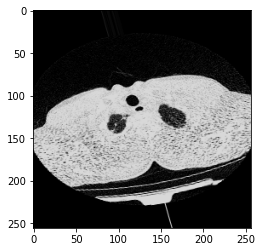

prediction:  1
covid status:  1.0


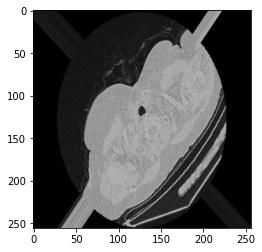

prediction:  0
covid status:  0.0


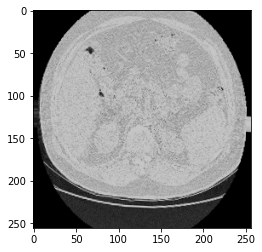

prediction:  0
covid status:  0.0


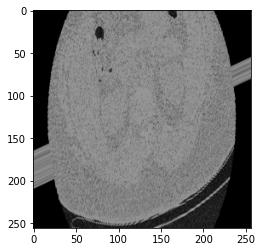

prediction:  0
covid status:  0.0


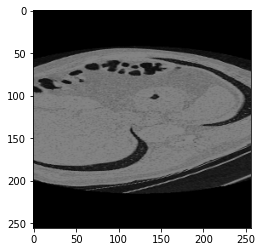

prediction:  0
covid status:  0.0


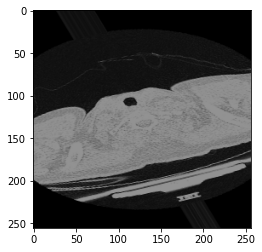

prediction:  0
covid status:  0.0


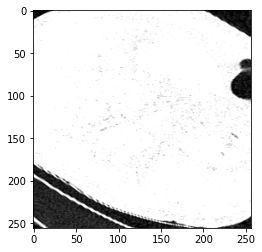

prediction:  0
covid status:  0.0


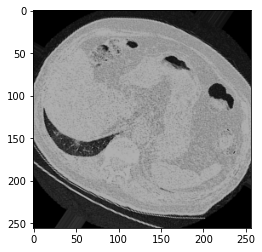

prediction:  0
covid status:  0.0


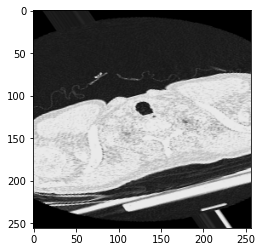

prediction:  0
covid status:  0.0


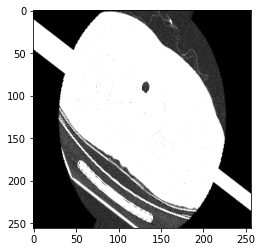

prediction:  0
covid status:  0.0


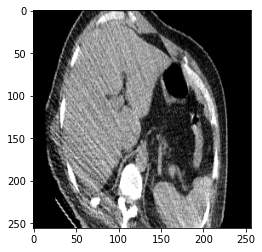

prediction:  0
covid status:  0.0


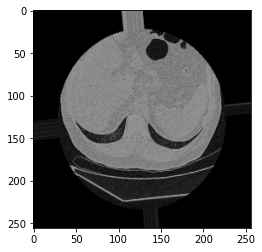

prediction:  0
covid status:  0.0


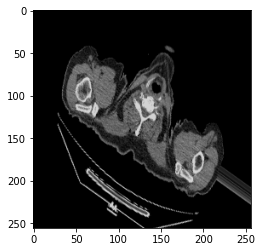

prediction:  0
covid status:  0.0


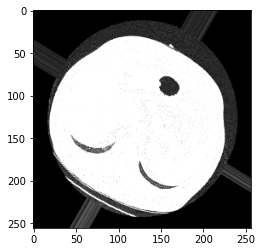

prediction:  0
covid status:  0.0


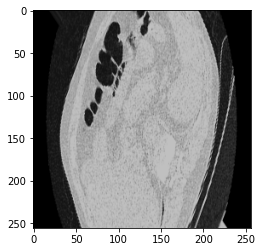

prediction:  0
covid status:  0.0


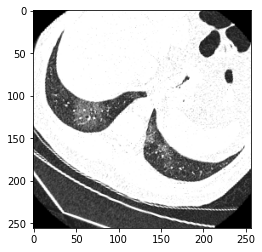

prediction:  0
covid status:  0.0


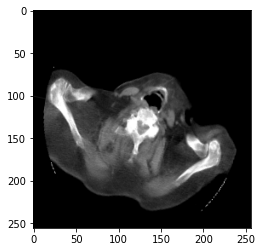

prediction:  1
covid status:  1.0


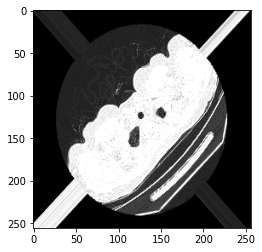

prediction:  0
covid status:  0.0


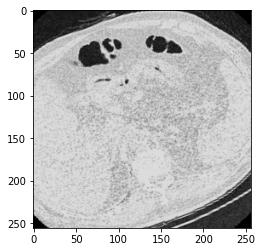

prediction:  0
covid status:  0.0


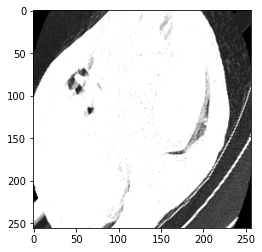

prediction:  0
covid status:  0.0


In [11]:
for i in range(0,20):    
    plt.imshow(X_test[i])
    plt.show()
    print("prediction: ", prdcs[i])
    print("covid status: ", y_test[i])

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [13]:
mat = confusion_matrix(y_test, prdcs)
print(mat)

[[111   0]
 [  1  12]]


[[111   0]
 [  1  12]]


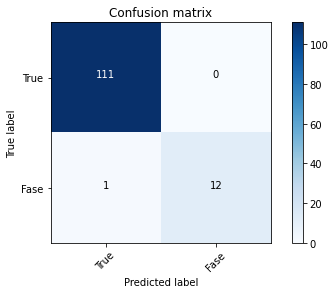

In [14]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
cm_label = ['True', 'Fase']
plot_confusion_matrix(mat, classes=cm_label, title='Confusion matrix')

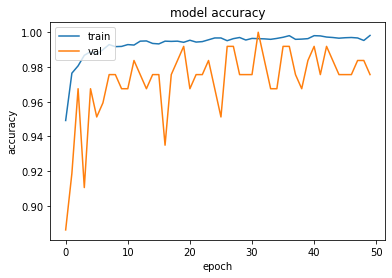

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

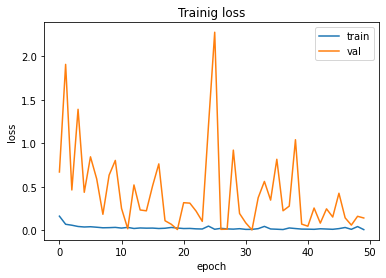

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Trainig loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()